In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torch import optim
from collections import OrderedDict

from tqdm import tqdm
import helper
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset
from torchvision.utils import make_grid
from torch.autograd import Variable

## Transformations

In [2]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

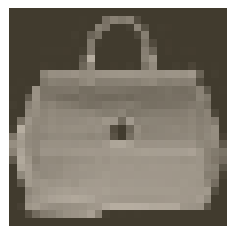

In [3]:
image, label = next(iter(trainloader))
helper.imshow(image[0,:]);

## Reshaping the images to a vector

In [4]:
class Reshape(torch.nn.Module):
    def forward(self, x):
        return x.view(-1,1,28,28)

## LeNet Model 

In [5]:
model = torch.nn.Sequential(
    Reshape(),
    nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(16*5*5, 120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.Sigmoid(),
    nn.Linear(84, 10))

In [6]:
model

Sequential(
  (0): Reshape()
  (1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (2): Sigmoid()
  (3): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (4): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (5): Sigmoid()
  (6): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (7): Flatten()
  (8): Linear(in_features=400, out_features=120, bias=True)
  (9): Sigmoid()
  (10): Linear(in_features=120, out_features=84, bias=True)
  (11): Sigmoid()
  (12): Linear(in_features=84, out_features=10, bias=True)
)

In [7]:
X = torch.randn(size=(1, 1, 28, 28), dtype=torch.float32)

In [8]:
for layer in model:
    X = layer(X)
    print(layer.__class__.__name__,'output shape: \t',X.shape)

Reshape output shape: 	 torch.Size([1, 1, 28, 28])
Conv2d output shape: 	 torch.Size([1, 6, 28, 28])
Sigmoid output shape: 	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape: 	 torch.Size([1, 6, 14, 14])
Conv2d output shape: 	 torch.Size([1, 16, 10, 10])
Sigmoid output shape: 	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape: 	 torch.Size([1, 16, 5, 5])
Flatten output shape: 	 torch.Size([1, 400])
Linear output shape: 	 torch.Size([1, 120])
Sigmoid output shape: 	 torch.Size([1, 120])
Linear output shape: 	 torch.Size([1, 84])
Sigmoid output shape: 	 torch.Size([1, 84])
Linear output shape: 	 torch.Size([1, 10])


## Loss Function and Hyperparameters 

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.9)

## Training 

In [10]:
epochs = 20
steps = 0

train_losses, test_losses = [], []
for e in tqdm(range(epochs)):
    running_loss = 0
    
    for images, labels in trainloader:
        optimizer.zero_grad()
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    else:
        test_loss = 0
        accuracy = 0
        
        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            for images, labels in testloader:
                log_ps = model(images)
                test_loss += criterion(log_ps, labels)
                
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
                
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))
        

print("Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)), 
        "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)), "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))

100%|██████████| 20/20 [07:45<00:00, 23.30s/it]

Training Loss: 0.246..  Test Loss: 0.294..  Test Accuracy: 0.893


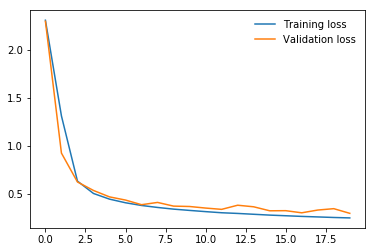

In [11]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

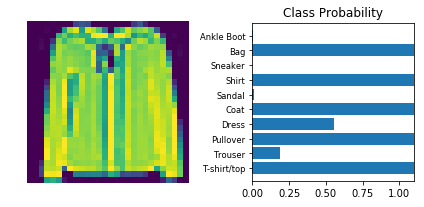

In [12]:
dataiter = iter(testloader)
images, labels = dataiter.next()
img = images[0]
ps = torch.exp(model(img))

# Plot the image and probabilities
helper.view_classify(img, ps, version='Fashion')

# Conclusion
The test accuracy is nearly 90 percent and the model performs satisfactorily classifying the new images as observed in above illustration of probability distribution. Here the model classifies the image into more than one similar classes. 